In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AnomalyDetection

/content/drive/MyDrive/AnomalyDetection


Imports required libraries

In [ ]:
import pandas as pd
import json
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict,List,Callable

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from functools import partial
from keras.utils import Sequence
from keras import regularizers

# **1.Data preprocessing**



## 1.1Prepare the data:
1.set binary label(0:normal, 1:failure)
2.In a given experiment, samples are considered “normal” before a “failure” is introduced. 
After a failure occurs, all consequent samples in that experiment are considered “failure”.

In [ ]:
# set seed for reproducibility
state = np.random.RandomState(42)

# load dataset
trainData = pd.read_csv('data/train.csv')
testData = pd.read_csv('data/test.csv')
trainData['time'] = pd.to_datetime(trainData['time'])
trainData.set_index('time', inplace=True)
testData['time'] = pd.to_datetime(testData['time'])
testData.set_index('time', inplace=True)

# Check for missing data
print('Any missing value on train set?',trainData.isnull().values.any())
print('Any missing value on test set?',testData.isnull().values.any())

# set label normal:0 failure:1
trainData["label"] = 0
testData["label"] = 0

#load json file
with open('data/failures_train.json', encoding='utf-8') as a:
  failures_train = json.load(a)
with open('data/failures_test.json', encoding='utf-8') as a:
  failures_test = json.load(a)

# transfer the label
for id, expid in enumerate(failures_train["exp_id"]):
  trainData.loc[(trainData['exp_id']==expid) & (trainData.index>=datetime.strptime(failures_train["failure_time"][id],"%Y-%m-%d %H:%M:%S")),["label"]] = 1

for id, expid in enumerate(failures_test["exp_id"]):
  testData.loc[(testData['exp_id']==expid) & (testData.index>=datetime.strptime(failures_test["failure_time"][id],"%Y-%m-%d %H:%M:%S")),["label"]] = 1

allData = pd.concat([trainData,testData])
print("All data shape:", allData.shape)


Any missing value on train set? False
Any missing value on test set? False
All data shape: (44496, 11)


Delete the experiment with data less than 5

In [ ]:
train_exp_id_counts = trainData['exp_id'].value_counts()
test_exp_id_counts = testData['exp_id'].value_counts()

print("Train set shape before remove experiment with data less than 5 :",trainData.shape)
print("Test set shape before remove experiment with data less than 5 ",testData.shape)

trainData = trainData[trainData.groupby('exp_id').exp_id.transform('count')>=5]
testData = testData[testData.groupby('exp_id').exp_id.transform('count')>=5]

print("Train set shape after remove experiment with data less than 5 :",trainData.shape)
print("Test set shape after remove experiment with data less than 5 ",testData.shape)

Train set shape before remove experiment with data less than 5 : (34071, 11)
Test set shape before remove experiment with data less than 5  (10425, 11)
Train set shape after remove experiment with data less than 5 : (34025, 11)
Test set shape after remove experiment with data less than 5  (10421, 11)


For the dataset, there are two versions: 

1. The given train and test set. (For unsupervised and supervised methods)

2. Move all the experiments with failure data to the test set. There are only normal data in the train set. Test set is mixed with normal and failure data.(For semi-supervised method)

In [ ]:
#at here, I create the dataset of version 2.

#check the failure and normal experiment data in train and test set
train_failure = trainData.loc[trainData['exp_id'].isin(failures_train["exp_id"])]
train_normal = trainData.loc[~trainData['exp_id'].isin(failures_train["exp_id"])]
test_failure = testData.loc[testData['exp_id'].isin(failures_test["exp_id"])]
test_normal = testData.loc[~testData['exp_id'].isin(failures_test["exp_id"])]
print("Train experiment data shape with failure:",train_failure.shape)
print("Train experiment data shape without failure:",train_normal.shape)
print("Test experiment data shape with failure:",test_failure.shape)
print("Test experiment data shape without failure:",test_normal.shape)

# combine all the normal experiment data 
normal_data = pd.concat([train_normal,test_normal],axis=0)
# combine all the failure experiment data 
failure_data = pd.concat([train_failure,test_failure],axis=0)
set1, set2 = train_test_split(normal_data, test_size=0.2, random_state=state)
#train set of version 2 
train_pure_normal = set1
#test set of version 2 
test_mix_normal_failure = pd.concat([set2,failure_data],axis=0)
print("Train set shape without failure:",train_pure_normal.shape)
print("Test set shape with normal and failure:",test_mix_normal_failure.shape)
print("Label distributation in the test set:")
test_mix_normal_failure["label"].value_counts()

Train experiment data shape with failure: (2554, 11)
Train experiment data shape without failure: (31471, 11)
Test experiment data shape with failure: (1860, 11)
Test experiment data shape without failure: (8561, 11)
Train set shape without failure: (32025, 11)
Test set shape with normal and failure: (12421, 11)
Label distributation in the test set:


0    10277
1     2144
Name: label, dtype: int64

In [ ]:
trainData.head()

,var-0,var-1,var-2,var-3,var-4,var-5,var-6,var-7,var-8,exp_id,label
time,,,,,,,,,,,
2020-03-31 15:42:00,1.795475,1.832359,56.060642,0.802059,0.799989,49.69724,18.895876,19.955881,45.92112,0,0
2020-03-31 15:43:00,1.795475,1.832359,56.060642,0.802059,0.799989,49.69724,18.895876,19.955881,45.92112,0,0
2020-03-31 15:44:00,1.795475,1.832359,56.060642,0.802059,0.799989,49.69724,18.895876,19.955881,45.92112,0,0
2020-03-31 15:45:00,1.795475,1.832359,56.060642,0.802059,0.799989,49.69724,18.895876,19.955881,45.92112,0,0
2020-03-31 15:46:00,1.795475,1.832359,56.060642,0.802059,0.799989,49.69724,18.895876,19.955881,45.92112,0,0


In [ ]:
trainData.describe()

,var-0,var-1,var-2,var-3,var-4,var-5,var-6,var-7,var-8,exp_id,label
count,34025.000000,34025.000000,34025.000000,34025.000000,34025.000000,34025.000000,34025.000000,34025.000000,34025.000000,34025.000000,34025.000000
mean,1.854379,1.854336,57.235945,0.774627,0.774611,55.264054,18.468623,18.468678,48.514386,20.117678,0.014607
std,0.227028,0.227042,13.987247,0.081508,0.081472,18.635870,2.963865,2.964084,21.003448,26.225645,0.119975
min,1.140073,1.140073,21.465650,0.457602,0.457602,1.397189,12.645188,12.645188,5.145267,0.000000,0.000000
25%,1.787821,1.787294,48.235467,0.701589,0.701603,44.385867,16.963259,16.961057,37.395677,0.000000,0.000000
50%,1.801437,1.801604,54.237175,0.799905,0.799920,52.045474,19.308362,19.312273,42.107212,5.000000,0.000000
75%,2.000430,2.000430,67.403953,0.801188,0.801162,65.534123,20.002599,20.002393,55.035110,53.000000,0.000000
max,2.534659,2.534659,99.767279,1.001031,1.001031,100.000000,26.071889,26.071873,100.000000,78.000000,1.000000


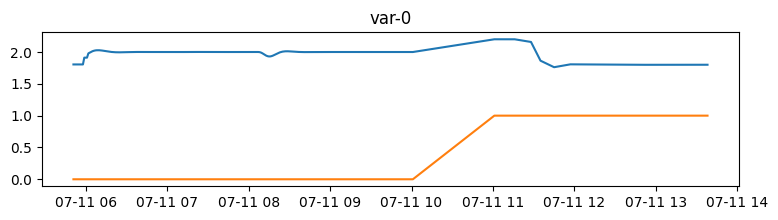

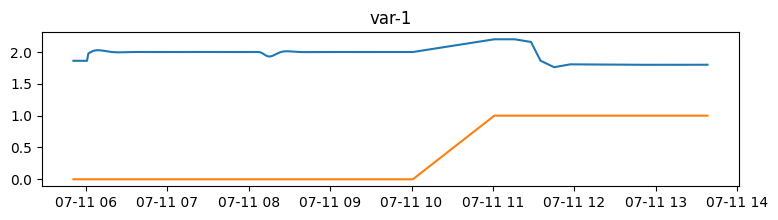

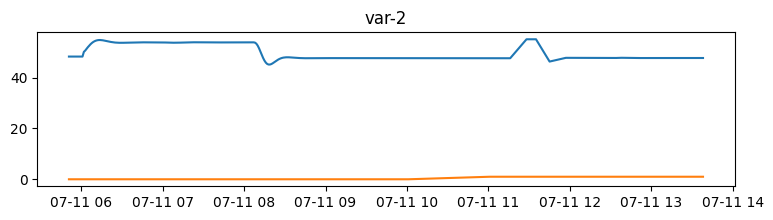

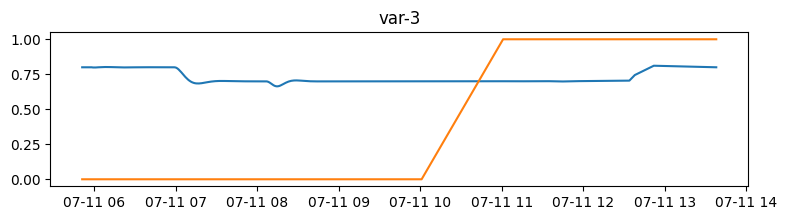

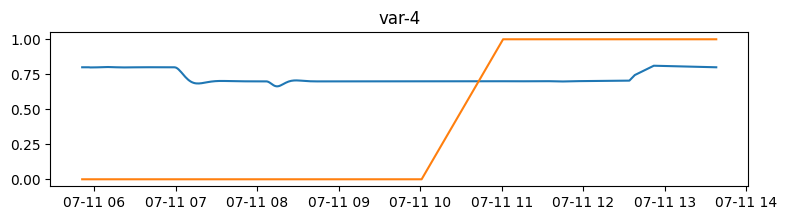

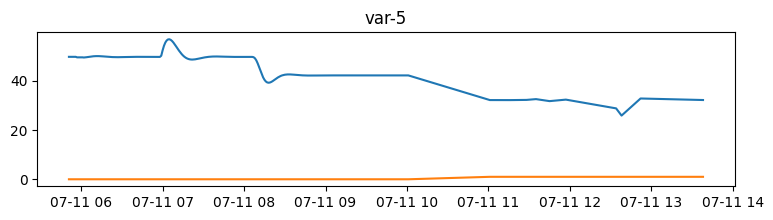

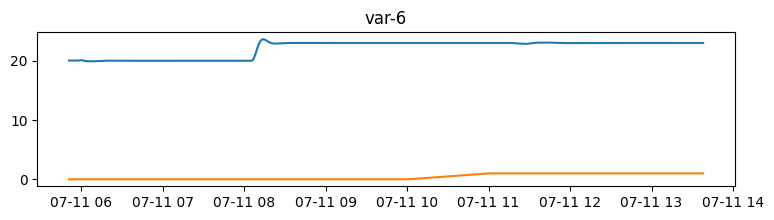

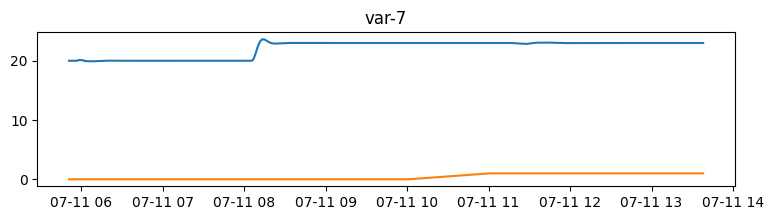

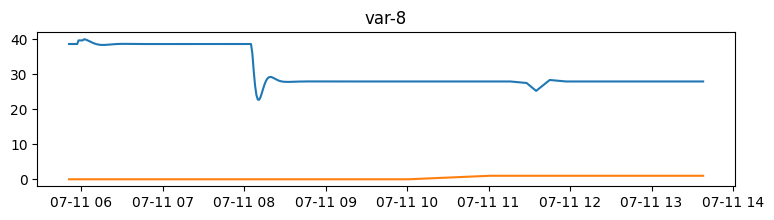

In [ ]:
#plot data of one experiment to see the relations between var and label
plotdata = trainData[trainData["exp_id"]==12]
plotdata = plotdata.drop("exp_id",axis = 1)
for col in plotdata.columns[:-1]:
    fig = plt.figure(figsize=(9,2))
    ax = plt.axes()
    plt.title(col)
    x = np.linspace(0, plotdata.shape[0])
    ax.plot(plotdata[col])
    ax.plot(plotdata['label'])

## 1.2Normalization
Compress the value of the data to between 0 and 1.

In [ ]:
minmaxScaler = MinMaxScaler()
all_minmax_scaled = minmaxScaler.fit_transform(allData.iloc[:,:-2])
all_minmax_scaled = pd.DataFrame(all_minmax_scaled,index=allData.index,columns=allData.columns[:-2])

train_minmax_scaled = minmaxScaler.transform(trainData.iloc[:,:-2])
train_minmax_scaled = pd.DataFrame(train_minmax_scaled,index=trainData.index,columns=trainData.columns[:-2])
test_minmax_scaled = minmaxScaler.transform(testData.iloc[:,:-2])
test_minmax_scaled = pd.DataFrame(test_minmax_scaled,index=testData.index,columns=testData.columns[:-2])

train_minmax_scaled_pure = minmaxScaler.transform(train_pure_normal.iloc[:,:-2])
train_minmax_scaled_pure = pd.DataFrame(train_minmax_scaled_pure,index=train_pure_normal.index,columns=train_pure_normal.columns[:-2])
test_minmax_scaled_mix = minmaxScaler.transform(test_mix_normal_failure.iloc[:,:-2])
test_minmax_scaled_mix = pd.DataFrame(test_minmax_scaled_mix,index=test_mix_normal_failure.index,columns=test_mix_normal_failure.columns[:-2])

print("Some examples after normalization:")
train_minmax_scaled[:3]

Some examples after normalization:


,var-0,var-1,var-2,var-3,var-4,var-5,var-6,var-7,var-8
time,,,,,,,,,
2020-03-31 15:42:00,0.469962,0.49641,0.440508,0.633858,0.63005,0.489845,0.465542,0.54449,0.429877
2020-03-31 15:43:00,0.469962,0.49641,0.440508,0.633858,0.63005,0.489845,0.465542,0.54449,0.429877
2020-03-31 15:44:00,0.469962,0.49641,0.440508,0.633858,0.63005,0.489845,0.465542,0.54449,0.429877


## 1.3Standardization
Scale the range of features to a normal distribution with a mean of 0 and a standard deviation of 1.

In [ ]:
standardScaler = StandardScaler()
all_standard_scaled = standardScaler.fit_transform(all_minmax_scaled)
all_standard_scaled = pd.DataFrame(all_standard_scaled,index=all_minmax_scaled.index,columns=all_minmax_scaled.columns)

train_standard_scaled = standardScaler.transform(train_minmax_scaled)
train_standard_scaled = pd.DataFrame(train_standard_scaled,index=train_minmax_scaled.index,columns=train_minmax_scaled.columns)
test_standard_scaled = standardScaler.transform(test_minmax_scaled)
test_standard_scaled = pd.DataFrame(test_standard_scaled,index=test_minmax_scaled.index,columns=test_minmax_scaled.columns)

train_standard_scaled_pure = standardScaler.transform(train_minmax_scaled_pure)
train_standard_scaled_pure = pd.DataFrame(train_standard_scaled_pure,index=train_minmax_scaled_pure.index,columns=train_minmax_scaled_pure.columns)
test_standard_scaled_mix = standardScaler.transform(test_minmax_scaled_mix)
test_standard_scaled_mix = pd.DataFrame(test_standard_scaled_mix,index=test_minmax_scaled_mix.index,columns=test_minmax_scaled_mix.columns)

print("Some examples after standardization:")
train_standard_scaled[:3]

Some examples after standardization:


,var-0,var-1,var-2,var-3,var-4,var-5,var-6,var-7,var-8
time,,,,,,,,,
2020-03-31 15:42:00,-0.193749,-0.022369,0.086548,0.274916,0.248736,-0.153259,0.07112,0.438447,-0.041195
2020-03-31 15:43:00,-0.193749,-0.022369,0.086548,0.274916,0.248736,-0.153259,0.07112,0.438447,-0.041195
2020-03-31 15:44:00,-0.193749,-0.022369,0.086548,0.274916,0.248736,-0.153259,0.07112,0.438447,-0.041195


## 1.4PCA
PCA(Principal Component Analysis) is a dimensionality reduction technique used to transform a high-dimensional dataset into a lower-dimensional space while preserving the most important information in the data.

The percentage of variance of the components: [4.20186481e-01 2.29003242e-01 2.20842517e-01 1.08276827e-01
 1.86486724e-02 2.95458326e-03 4.52335105e-05 2.26517993e-05
 1.97919624e-05]
The variance values of the components: [3.78176332e+00 2.06107550e+00 1.98762732e+00 9.74513343e-01
 1.67841823e-01 2.65918469e-02 4.07110744e-04 2.03870776e-04
 1.78131665e-04]


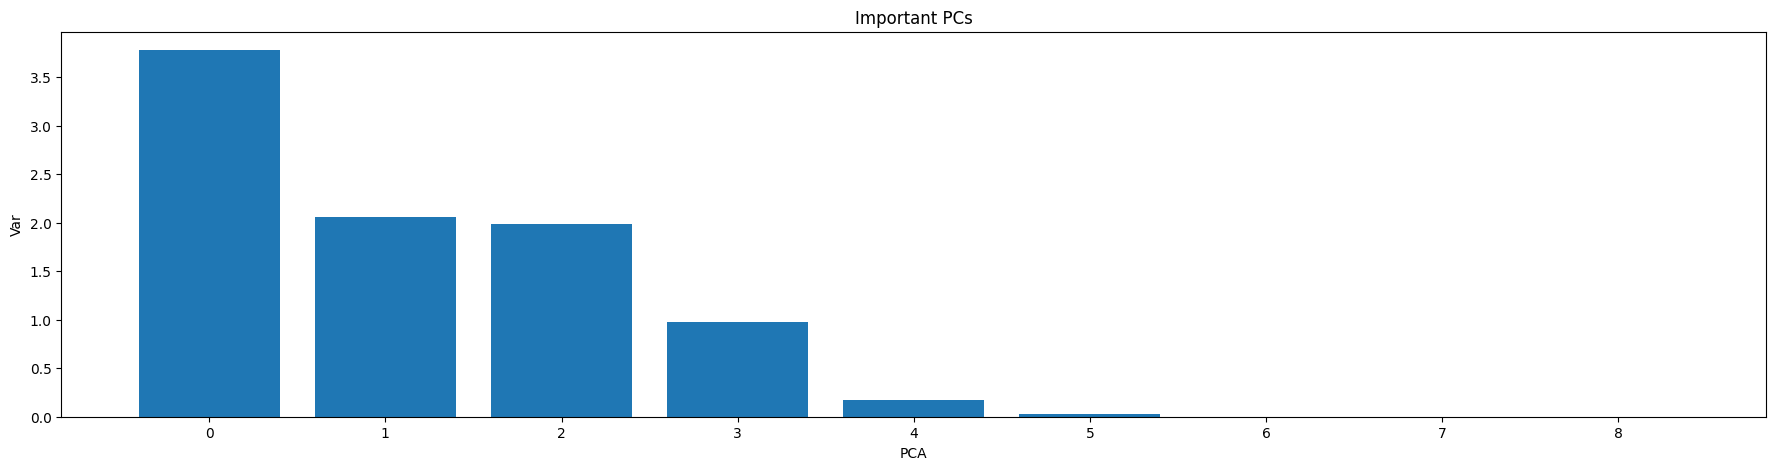

In [ ]:
pca = PCA(n_components = 9)
pca.fit(all_standard_scaled)
newData=pca.transform(all_standard_scaled)
print('The percentage of variance of the components:',pca.explained_variance_ratio_)
print('The variance values of the components:',pca.explained_variance_ )

features = range(pca.n_components_)
plt.figure(figsize=(22, 5))
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA')
plt.ylabel('Var')
plt.xticks(features)
plt.title("Important PCs")
plt.show()

In [ ]:
pca = PCA(n_components=6)
train_pca = pca.fit_transform(train_standard_scaled)
train_pca = pd.DataFrame(data=train_pca)
test_pca = pca.transform(test_standard_scaled)
test_pca = pd.DataFrame(data=test_pca)

# **2. Unsupervised Methods**



*   Robust covariance:  It is a statistical technique used to estimate the covariance matrix of a dataset in the presence of outliers. It assumes that data comes from a known distribution such as Gaussian distribution.
*   Isolation Forest: This algorithm recursively randomly splits the data set until all sample points are isolated. In this random segmentation strategy, outliers usually have short paths.
*   Local Outlier Factor: It measures the local deviation of the density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood.

In [ ]:
classifiers = {
    "Robust covariance":EllipticEnvelope(contamination=0.15,random_state=state),
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=trainData.shape[0],contamination=0.15,random_state=state),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=40, algorithm='auto',leaf_size=30, metric='minkowski',p=2, metric_params=None, contamination=0.2, novelty=True),
    # "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05,max_iter=-1)
   
}

In [ ]:
n_outliers = allData["label"].value_counts()[1]

def ml_methods(classifiers, data,test, label):
  for i, (clf_name,clf) in enumerate(classifiers.items()):
      #Fit the data and tag outliers
      if clf_name == "Local Outlier Factor":
          clf.fit(data)
          y_pred = clf.predict(test)
          scores_prediction = clf.negative_outlier_factor_
      elif clf_name == "Support Vector Machine":
          clf.fit(data)
          y_pred = clf.predict(test)
      elif clf_name == "Robust covariance":
          clf.fit(data)
          y_pred = clf.predict(test)
      else:    
          clf.fit(data)
          scores_prediction = clf.decision_function(data)
          y_pred = clf.predict(test)
      #Reshape the prediction values to 0 for normal, 1 for failure
      y_pred[y_pred == 1] = 0
      y_pred[y_pred == -1] = 1
      n_errors = (y_pred != label).sum()
      # Run Classification Metrics
      print("{}: {}".format(clf_name,n_errors))
      print("F1 Score :")
      print(f1_score(label,y_pred))
      print("Classification Report :")
      print(classification_report(label,y_pred))

ml_methods(classifiers,train_pca,test_pca,testData["label"])

Robust covariance: 4530
F1 Score :
0.03617021276595745
Classification Report :
              precision    recall  f1-score   support

           0       0.79      0.66      0.72      8774
           1       0.03      0.05      0.04      1647

    accuracy                           0.57     10421
   macro avg       0.41      0.36      0.38     10421
weighted avg       0.67      0.57      0.61     10421

Isolation Forest: 1602
F1 Score :
0.6315547378104875
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      8774
           1       0.51      0.83      0.63      1647

    accuracy                           0.85     10421
   macro avg       0.74      0.84      0.77     10421
weighted avg       0.89      0.85      0.86     10421

Local Outlier Factor: 2053
F1 Score :
0.5056585600770527
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.83      0.88      8774


In [ ]:
# plot the accuracy and loss
def show_history(history):
    epochs = history.epoch
    if 'accuracy' in history.history:
      acc = history.history['accuracy']
      val_acc = history.history['val_accuracy']
      #accuracy image
      plt.plot(epochs,acc, 'b', label='Training accuracy')
      plt.plot(epochs, val_acc, 'r', label='validation accuracy')
      plt.title('Training and validation accuracy')
      plt.legend(loc='lower right')
      plt.figure()
      plt.show()
    if 'loss' in history.history:  
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      plt.plot(loss, 'r', label='Training loss')
      plt.plot(val_loss, 'b', label='validation loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.show()
    if 'mse' in history.history: 
      mse = history.history['mse']
      val_mse = history.history['val_mse']
      plt.plot(epochs, mse, 'r', label='Training mse loss')
      plt.plot(epochs, val_mse, 'b', label='validation mse loss')
      plt.title('Training and validation mse loss')
      plt.legend()
      plt.show() 
    if 'mae' in history.history: 
      mae = history.history['mae']
      val_mae = history.history['val_mae']
      plt.plot(epochs, mae, 'r', label='Training mae loss')
      plt.plot(epochs, val_mae, 'b', label='validation mae loss')
      plt.title('Training and validation mae loss')
      plt.legend()
      plt.show() 


def train_model(model,train,label,val,training_info: Dict):

    print("Start training! \nParameters: {}".format(training_info))
    if label is not None:
      history = model.fit(x=train,y=label,validation_data=val, **training_info)
    else:
      history = model.fit(x=train,validation_data=val, **training_info)
    print("Training completed! Showing history...")

    show_history(history)

    return model

def predict_data(model, x_test, prediction_info: Dict):

    print('Starting prediction: \n{}'.format(prediction_info))
    print('Predicting on {} samples'.format(x_test.shape[0]))

    predictions = model.predict(x_test, **prediction_info)
    return predictions


def evaluate_predictions(predictions, y, metrics, metric_names):

    assert len(metrics) == len(metric_names)
    print("Evaluating predictions! Total samples: ", y.shape[0])
    metric_info = {}

    for metric, metric_name in zip(metrics, metric_names):
        metric_value = metric(y_pred=predictions, y_true=y)
        metric_info[metric_name] = metric_value

    return metric_info

def plot_cm(test_label,test_prediction):
  cf_matrix = confusion_matrix(test_label,test_prediction)
  disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=[0,1])
  disp.plot()
  plt.show()

# prediction info
prediction_info = {
    'batch_size': 16,
    'verbose': 1
}

# Evaluation info
metrics = [
    partial(f1_score, pos_label=1, average='binary')
]
metric_names = [
    "binary_f1"
]

# 3.Semi-supervised method

In [ ]:
# Data generator for generating sequence windows 
class DataGenerator(Sequence):   
    def __init__(self, X, y, exp_id, batch_size, seq_len=1):
        self.X = np.array(X)
        self.y = np.array(y)
        self.exp_id = exp_id
        self.batch_size = batch_size
        self.seq_len = seq_len
      
    # return number of batches 
    def __len__(self):
        return (len(self.X) - (self.seq_len - 1) * len(self.exp_id.value_counts())) // self.batch_size

    def __getitem__(self, index):
        batch_index=[]
        i=0
        while i < self.batch_size:
          if self.exp_id.iloc[index] != self.exp_id.iloc[index+self.seq_len]:
            index+=1
          else:
            batch_index.append(index)
            i+=1
        
        data = np.array([self.X[index:index+self.seq_len] for index in batch_index])
        # label = np.array([self.y[index:index+self.seq_len] for index in batch_index])

        return data,data

In [ ]:
def autoencoder(compile_info: Dict):

  encoding_dim = 32
  input_dim = 9
  dataInput = Input(shape=(None,None,input_dim))
  encoder1 = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(dataInput)
  encoder2 = Dense(int(encoding_dim / 2), activation="relu")(encoder1)
  encoder3 = Dense(int(encoding_dim / 4), activation="relu")(encoder2)
  decoder1 = Dense(int(encoding_dim / 4), activation='tanh')(encoder3)
  decoder2 = Dense(int(encoding_dim / 2), activation='tanh')(decoder1)
  decoder3 = Dense(input_dim, activation='relu')(decoder2)

  model = Model(inputs=dataInput, outputs=decoder3)  
  model.summary()
  model.compile(**compile_info)

  return model


In [ ]:
#这里用的应该是全normal的traindata
autoencoder_compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-4),
    'loss': 'mse',
    'metrics':['mae']
}
autoencoder = autoencoder(autoencoder_compile_info)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 9)]   0         
                                                                 
 dense (Dense)               (None, None, None, 32)    320       
                                                                 
 dense_1 (Dense)             (None, None, None, 16)    528       
                                                                 
 dense_2 (Dense)             (None, None, None, 8)     136       
                                                                 
 dense_3 (Dense)             (None, None, None, 8)     72        
                                                                 
 dense_4 (Dense)             (None, None, None, 16)    144       
                                                                 
 dense_5 (Dense)             (None, None, None, 9)     153   

In [ ]:
#split the train set for autoencoder to train and val
#This train set only contains normal data
exp_ids = train_pure_normal["exp_id"].unique()
train, val = train_test_split(exp_ids, test_size=0.2,random_state=state)
val_auto = train_standard_scaled_pure.loc[train_pure_normal['exp_id'].isin(val)]
val_label_auto = train_pure_normal["label"].loc[train_pure_normal['exp_id'].isin(val)]
val_exp_id_auto = train_pure_normal["exp_id"].loc[train_pure_normal['exp_id'].isin(val)]
train_label_auto = train_pure_normal["label"].loc[train_pure_normal['exp_id'].isin(train)]
train_exp_id_auto = train_pure_normal["exp_id"].loc[train_pure_normal['exp_id'].isin(train)]
train_auto = train_standard_scaled_pure.loc[train_pure_normal['exp_id'].isin(train)]
test_auto = test_standard_scaled_mix
test_label_auto = test_mix_normal_failure["label"]

print("For autoencoder, the train set shape is:", train_auto.shape)
print("For autoencoder, the val set shape is:", val_auto.shape)

For autoencoder, the train set shape is: (28868, 9)
For autoencoder, the val set shape is: (3157, 9)


Start training! 
Parameters: {'verbose': 1, 'epochs': 50, 'batch_size': 16}
Epoch 1/50
574/574 [==============================] - 11s 11ms/step - loss: 0.8326 - mae: 0.6727 - val_loss: 1.2785 - val_mae: 0.9110
Epoch 2/50
574/574 [==============================] - 7s 12ms/step - loss: 0.6832 - mae: 0.5970 - val_loss: 1.2190 - val_mae: 0.8846
Epoch 3/50
574/574 [==============================] - 3s 5ms/step - loss: 0.6304 - mae: 0.5677 - val_loss: 1.1652 - val_mae: 0.8540
Epoch 4/50
574/574 [==============================] - 4s 7ms/step - loss: 0.5844 - mae: 0.5257 - val_loss: 1.1041 - val_mae: 0.8174
Epoch 5/50
574/574 [==============================] - 3s 5ms/step - loss: 0.5451 - mae: 0.4895 - val_loss: 1.0423 - val_mae: 0.7805
Epoch 6/50
574/574 [==============================] - 3s 5ms/step - loss: 0.5204 - mae: 0.4729 - val_loss: 1.0281 - val_mae: 0.7734
Epoch 7/50
574/574 [==============================] - 3s 6ms/step - loss: 0.5042 - mae: 0.4637 - val_loss: 1.0282 - val_mae: 0.78

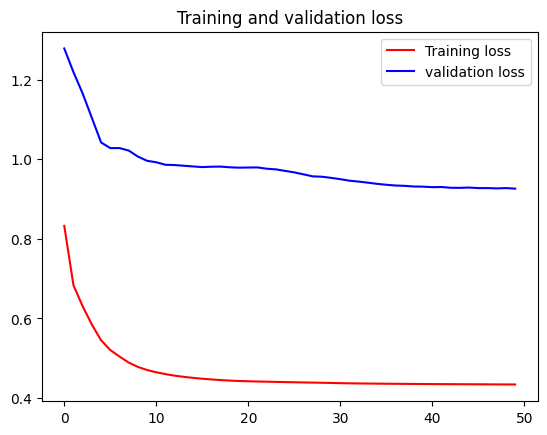

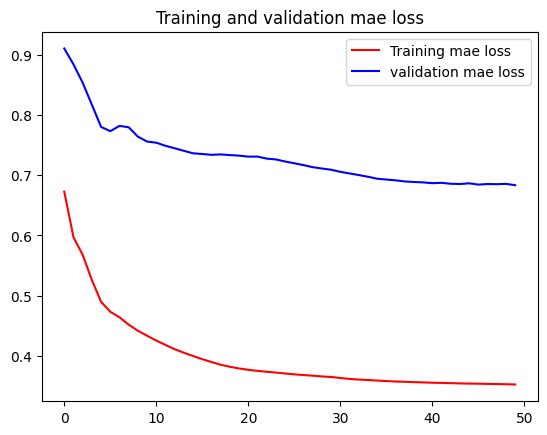

In [ ]:
#train the model

# Training info
autoencoder_training_info = {
    'verbose': 1,
    'epochs': 50,
    'batch_size': 16
}
sequence_length = 5
batch_size = autoencoder_training_info["epochs"]
train_gen = DataGenerator(train_auto, train_label_auto, train_exp_id_auto ,batch_size,sequence_length)
val_gen = DataGenerator(val_auto,val_label_auto,val_exp_id_auto,batch_size,sequence_length)
train_model(model=autoencoder,train=train_gen,label=None,val=val_gen,training_info=autoencoder_training_info)

Starting prediction: 
{'batch_size': 16, 'verbose': 1}
Predicting on 28700 samples
1794/1794 [==============================] - 4s 2ms/step


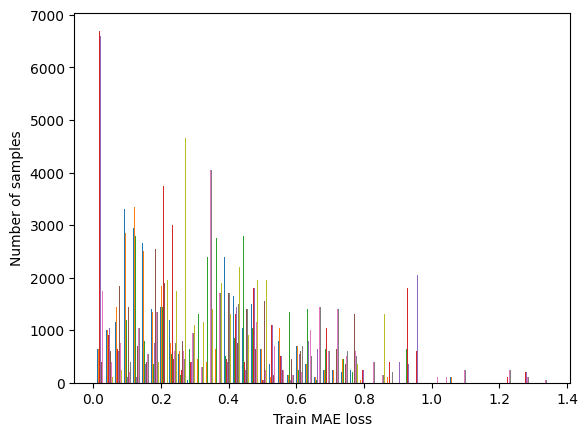

Reconstruction error threshold:  0.7928408310581084
Starting prediction: 
{'batch_size': 16, 'verbose': 1}
Predicting on 12421 samples
777/777 [==============================] - 1s 1ms/step


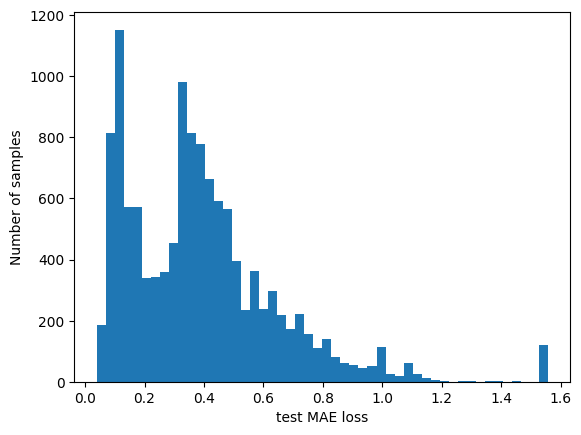

Number of anomaly samples:  839
Evaluating predictions! Total samples:  12421
Metrics info: 
{'binary_f1': 0.025477707006369425}


In [ ]:
# Get all data
all_data=[]
for batch_index in range(len(train_gen)):
    data, _ = train_gen[batch_index]
    all_data.append(data)

# Concatenate the data from all batches into a single array
all_data = np.concatenate(all_data, axis=0)

# Get train MAE loss.
auto_train_pred = predict_data(model=autoencoder, x_test=all_data, prediction_info=prediction_info)
train_mae_loss = np.mean(np.abs(auto_train_pred - all_data), axis=1)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of samples")
plt.show()
# Get reconstruction loss threshold
threshold = np.percentile(train_mae_loss, 95)
# threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


# Get test MAE loss.
auto_test_pred = predict_data(model=autoencoder, x_test=test_auto, prediction_info=prediction_info)
test_mae_loss = np.mean(np.abs(auto_test_pred - test_auto), axis=1)
test_mae_loss = test_mae_loss.values.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("Number of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))

auto_metric_info = evaluate_predictions(predictions=anomalies,y=test_label_auto,metrics=metrics,metric_names=metric_names)
print('Metrics info: \n{}'.format(auto_metric_info))

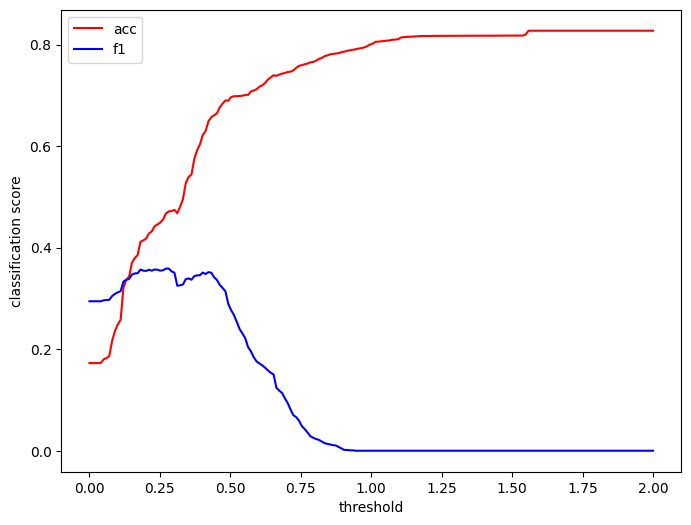

threshold: 0.271,  f1 score: 0.359


In [ ]:
# find the best threshold for a higher f1 score

threshold = np.linspace(0, 2, 200)
acc_list = []
f1_list = []

for t in threshold:
    anomalies = test_mae_loss > t
    acc_list.append(accuracy_score(anomalies, test_label_auto))
    f1_list.append(f1_score(anomalies, test_label_auto))

plt.figure(figsize=(8, 6))
plt.plot(threshold, acc_list, 'r', label='acc')
plt.plot(threshold, f1_list, 'b', label='f1')
plt.xlabel('threshold')
plt.ylabel('classification score')
plt.legend()
plt.show()

i = np.argmax(f1_list)
t = threshold[i]
score = f1_list[i]
print('threshold: %.3f,  f1 score: %.3f' % (t, score))

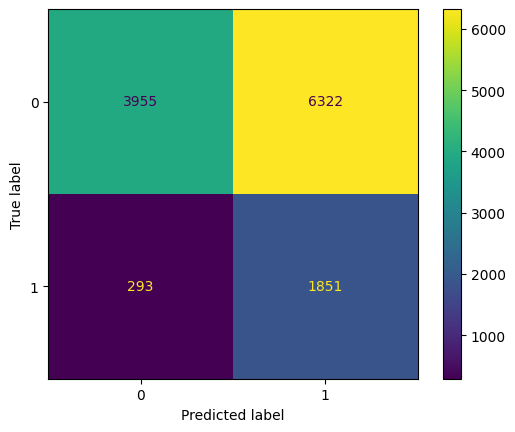

In [ ]:
# show the confusion matrix
anomalies = test_mae_loss > t
plot_cm(test_label_auto,anomalies)

# 4.Supervised method

In [ ]:
def build_lstm_model(compile_info: Dict) -> keras.Model:

    #input layer
    dataInput=Input(shape=(9,1,))
    
    #lstm layer
    lstm_output = LSTM(64)(dataInput)
    dense_output1 = Dense(units = 256, activation = "relu", name="dense_1")(lstm_output)
    dense_output2 = Dense(units = 64, activation = "relu", name="dense_2")(dense_output1)
    dropout_output = Dropout(0.2)(dense_output2)
    last_output = Dense(units = 1, activation = "sigmoid", name="logits")(dropout_output)

    model = Model(inputs=dataInput, outputs=last_output)  
    model.summary()
    model.compile(**compile_info)

    return model

In [ ]:
lstm_compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=5e-4),
    'loss': 'binary_crossentropy',
    'metrics': ['mse'],
}
lstmModel = build_lstm_model(lstm_compile_info)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9, 1)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 logits (Dense)              (None, 1)                 65        
                                                                 
Total params: 50,049
Trainable params: 50,049
Non-trainable

In [ ]:
#split the train set into train and val set based on the experiment id

exp_ids = trainData["exp_id"].unique()
train, val = train_test_split(exp_ids, test_size=0.15,random_state=state)
val_lstm = train_standard_scaled.loc[trainData['exp_id'].isin(val)]
print("Val dataset shape:",val_lstm.shape)
val_lstm_label = trainData["label"].loc[trainData['exp_id'].isin(val)]
val_lstm_exp_id = trainData["exp_id"].loc[trainData['exp_id'].isin(val)]
train_lstm_label = trainData["label"].loc[trainData['exp_id'].isin(train)]
train_lstm_exp_id = trainData["exp_id"].loc[trainData['exp_id'].isin(train)]
train_lstm = train_standard_scaled.loc[trainData['exp_id'].isin(train)]
print("Train dataset shape:",train_lstm.shape)
test_lstm_label = testData["label"]
test_lstm_exp_id = testData["exp_id"]
test_lstm = test_standard_scaled

Val dataset shape: (2900, 9)
Train dataset shape: (31125, 9)


Start training! 
Parameters: {'verbose': 1, 'epochs': 30, 'batch_size': 16}
Epoch 1/30
1946/1946 [==============================] - 19s 10ms/step - loss: 0.0121 - mse: 0.0029 - val_loss: 0.0877 - val_mse: 0.0213
Epoch 2/30
1946/1946 [==============================] - 17s 9ms/step - loss: 0.0099 - mse: 0.0023 - val_loss: 0.0736 - val_mse: 0.0187
Epoch 3/30
1946/1946 [==============================] - 17s 9ms/step - loss: 0.0091 - mse: 0.0022 - val_loss: 0.0908 - val_mse: 0.0224
Epoch 4/30
1946/1946 [==============================] - 17s 9ms/step - loss: 0.0089 - mse: 0.0022 - val_loss: 0.1135 - val_mse: 0.0239
Epoch 5/30
1946/1946 [==============================] - 17s 9ms/step - loss: 0.0093 - mse: 0.0024 - val_loss: 0.1138 - val_mse: 0.0243
Epoch 6/30
1946/1946 [==============================] - 16s 8ms/step - loss: 0.0077 - mse: 0.0018 - val_loss: 0.1895 - val_mse: 0.0317
Epoch 7/30
1946/1946 [==============================] - 17s 9ms/step - loss: 0.0083 - mse: 0.0020 - val_loss: 0.1

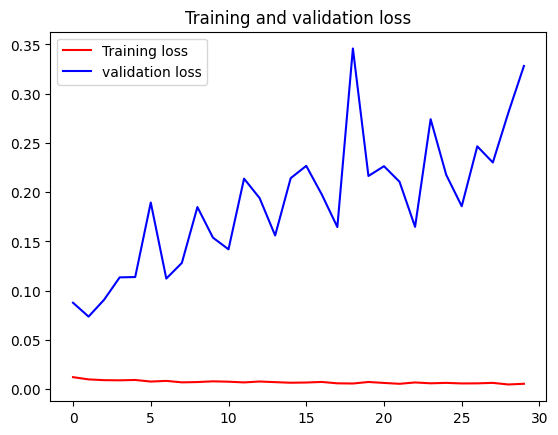

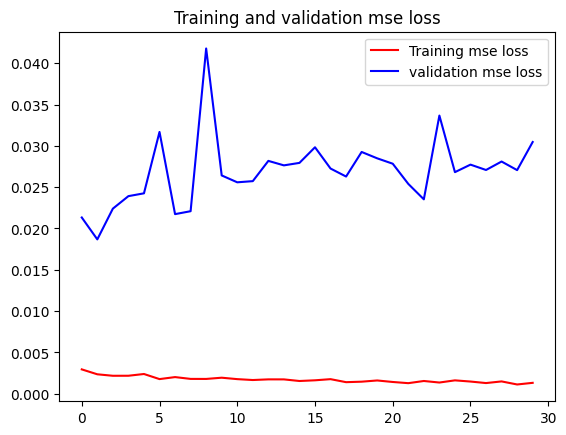

In [ ]:
#reshape the data to fit the model
train_reshaped = train_lstm.values.reshape(train_lstm.shape[0],train_lstm.shape[1],1)
val_reshaped = val_lstm.values.reshape(val_lstm.shape[0],val_lstm.shape[1],1)

# Training info
lstm_training_info = {
    'verbose': 1,
    'epochs': 30,
    'batch_size': 16
}
# train the model
train_model(model=lstmModel,train=train_reshaped,label=train_lstm_label,val=(val_reshaped,val_lstm_label),training_info=lstm_training_info)

Starting prediction: 
{'batch_size': 16, 'verbose': 1}
Predicting on 10421 samples
652/652 [==============================] - 3s 2ms/step
Evaluating predictions! Total samples:  10421
Metrics info: 
{'binary_f1': 0.8001456133964325}


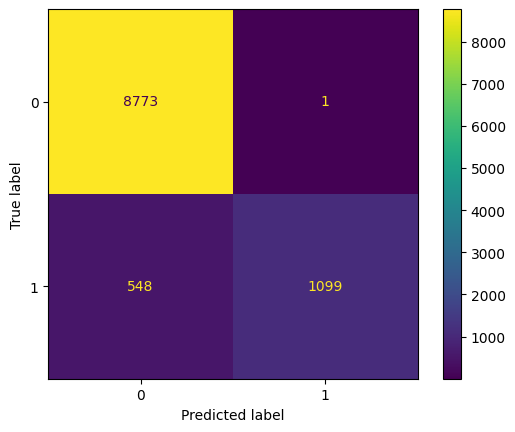

In [ ]:
# test the model
test_reshaped=test_lstm.values.reshape(test_lstm.shape[0],test_lstm.shape[1],1)
test_predictions = predict_data(model=lstmModel, x_test=test_reshaped, prediction_info=prediction_info)
test_predictions = np.round(test_predictions,0).astype(np.int32)
metric_info = evaluate_predictions(predictions=test_predictions,y=test_lstm_label,metrics=metrics,metric_names=metric_names)
print('Metrics info: \n{}'.format(metric_info))

#plot the confusion matrix
plot_cm(test_lstm_label,test_predictions)